In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from zoo.zouwu.autots.forecast import AutoTSTrainer
%matplotlib inline

In [2]:
# plot the predicted values and actual values (for the test data)
def plot_result(test_df, pred_df, dt_col="datetime", value_col="values", past_seq_len=1):
    # target column of dataframe is "value"
    # default past sequence length is 1
    pred_value = pred_df[value_col].values
    true_value = test_df[value_col].values[past_seq_len:]
    fig, axs = plt.subplots(figsize=(12, 5))

    axs.plot(pred_df[dt_col], pred_value, color='red', label='predicted values')
    axs.plot(test_df[dt_col][past_seq_len:], true_value, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('counter values')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
raw_df = pd.read_csv("/home/ding/data/nokia/mavenir/RRC.csv")
df = raw_df.dropna()
df['datetime']= pd.to_datetime(df['timestamp'])

/home/ding/anaconda3/envs/conda_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
df.head(200)

,values,timestamp,datetime
0,0.156434,2018-04-24 00:00:00,2018-04-24 00:00:00
1,0.190809,2018-04-24 00:00:15,2018-04-24 00:00:15
2,0.374607,2018-04-24 00:00:30,2018-04-24 00:00:30
3,0.406737,2018-04-24 00:00:45,2018-04-24 00:00:45
4,0.275637,2018-04-24 00:01:00,2018-04-24 00:01:00
...,...,...,...
195,0.484810,2018-04-24 00:48:45,2018-04-24 00:48:45
196,0.406737,2018-04-24 00:49:00,2018-04-24 00:49:00
197,0.173648,2018-04-24 00:49:15,2018-04-24 00:49:15
198,0.156434,2018-04-24 00:49:30,2018-04-24 00:49:30


<AxesSubplot:xlabel='datetime'>

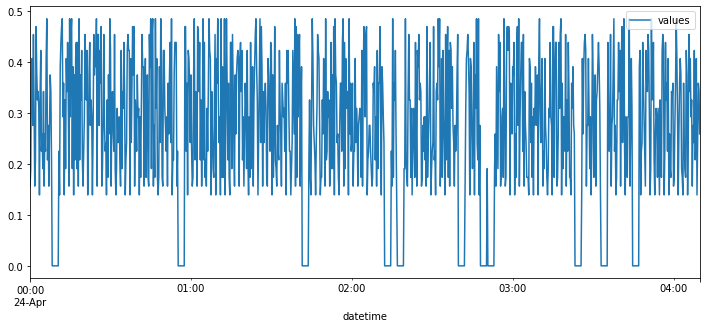

In [28]:
df[:1000].plot(x="datetime",y="values", figsize=(12, 5))

In [5]:
df.tail()

,values,timestamp,datetime
11516,0.292372,2018-04-25 23:59:00,2018-04-25 23:59:00
11517,0.190809,2018-04-25 23:59:15,2018-04-25 23:59:15
11518,0.422618,2018-04-25 23:59:30,2018-04-25 23:59:30
11519,0.258819,2018-04-25 23:59:45,2018-04-25 23:59:45
11520,0.139173,2018-04-26 00:00:00,2018-04-26 00:00:00


In [7]:
from zoo import init_spark_on_local
from zoo.ray import RayContext
sc = SparkContext.getOrCreate()
sc.stop()

sc = init_spark_on_local(cores=4, spark_log_level="INFO")
ray_ctx = RayContext(sc=sc, object_store_memory="1g")
ray_ctx.init()

Current pyspark location is : /home/ding/Downloads/spark-2.4.3-bin-hadoop2.7/python/pyspark/__init__.py
Start to getOrCreate SparkContext


2020-12-04 16:19:54,052	INFO resource_spec.py:212 -- Starting Ray with 18.9 GiB memory available for workers and up to 0.93 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Successfully got a SparkContext


2020-12-04 16:19:54,437	INFO services.py:1148 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '10.241.98.64', 'redis_address': '10.241.98.64:63361', 'object_store_address': '/tmp/ray/session_2020-12-04_16-19-54_051233_20065/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2020-12-04_16-19-54_051233_20065/sockets/raylet', 'webui_url': 'localhost:8265', 'session_dir': '/tmp/ray/session_2020-12-04_16-19-54_051233_20065'}


{'node_ip_address': '10.241.98.64',
 'redis_address': '10.241.98.64:63361',
 'object_store_address': '/tmp/ray/session_2020-12-04_16-19-54_051233_20065/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-12-04_16-19-54_051233_20065/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-12-04_16-19-54_051233_20065'}

In [8]:
from zoo.zouwu.autots.forecast import AutoTSTrainer

trainer = AutoTSTrainer(dt_col="datetime",
                        target_col="values",
                        horizon=1,
                        extra_features_col=None)

In [9]:
look_back = (4, 10)

In [10]:
from zoo.automl.common.util import train_val_test_split
train_df, val_df, test_df = train_val_test_split(df, 
                                                 val_ratio=0.1, 
                                                 test_ratio=0.02,
                                                 look_back=look_back[0])

In [11]:
from zoo.automl.config.recipe import LSTMGridRandomRecipe
ts_pipeline = trainer.fit(train_df, val_df, 
                          recipe=LSTMGridRandomRecipe(
                              num_rand_samples=3,
                              epochs=10,
                              look_back=look_back, 
                              batch_size=[64]))

Trial name,status,loc,batch_size,dropout_2,lr,lstm_1_units,lstm_2_units,past_seq_len,selected_features,iter,total time (s)
train_func_00000,TERMINATED,,64,0.495815,0.00552683,64,16,6,"[""IS_AWAKE(datetime)"", ""WEEKDAY(datetime)"", ""HOUR(datetime)"", ""DAYOFYEAR(datetime)"", ""WEEKOFYEAR(datetime)"", ""IS_BUSY_HOURS(datetime)"", ""MINUTE(datetime)""]",10,179.665
train_func_00001,TERMINATED,,64,0.378113,0.00111924,64,32,4,"[""MINUTE(datetime)"", ""MONTH(datetime)"", ""WEEKOFYEAR(datetime)"", ""HOUR(datetime)"", ""DAYOFYEAR(datetime)""]",10,151.015
train_func_00002,TERMINATED,,64,0.313862,0.00464593,16,64,5,"[""MINUTE(datetime)"", ""WEEKDAY(datetime)"", ""DAYOFYEAR(datetime)"", ""IS_BUSY_HOURS(datetime)"", ""HOUR(datetime)"", ""IS_AWAKE(datetime)"", ""MONTH(datetime)"", ""IS_WEEKEND(datetime)"", ""DAY(datetime)"", ""WEEKOFYEAR(datetime)""]",10,159.254
train_func_00003,TERMINATED,,64,0.400064,0.00746083,32,16,7,"[""IS_AWAKE(datetime)"", ""IS_BUSY_HOURS(datetime)"", ""WEEKOFYEAR(datetime)"", ""WEEKDAY(datetime)"", ""IS_WEEKEND(datetime)"", ""DAY(datetime)"", ""MINUTE(datetime)"", ""MONTH(datetime)""]",10,183.151
train_func_00004,TERMINATED,,64,0.235391,0.00664234,16,32,6,"[""DAYOFYEAR(datetime)"", ""IS_WEEKEND(datetime)"", ""HOUR(datetime)"", ""IS_AWAKE(datetime)""]",10,177.042
train_func_00005,TERMINATED,,64,0.28306,0.00589113,64,64,9,"[""IS_WEEKEND(datetime)"", ""IS_AWAKE(datetime)"", ""MONTH(datetime)"", ""HOUR(datetime)"", ""WEEKOFYEAR(datetime)""]",10,236.527
train_func_00006,TERMINATED,,64,0.343529,0.00546051,64,16,4,"[""MINUTE(datetime)"", ""WEEKDAY(datetime)"", ""IS_AWAKE(datetime)""]",10,153.647
train_func_00007,TERMINATED,,64,0.459407,0.00505081,16,32,9,"[""IS_WEEKEND(datetime)"", ""DAYOFYEAR(datetime)"", ""MINUTE(datetime)""]",10,211.169
train_func_00008,TERMINATED,,64,0.381077,0.0016649,16,64,7,"[""IS_WEEKEND(datetime)"", ""IS_BUSY_HOURS(datetime)"", ""DAYOFYEAR(datetime)"", ""WEEKOFYEAR(datetime)"", ""HOUR(datetime)"", ""IS_AWAKE(datetime)"", ""MINUTE(datetime)""]",10,186.314


best log dir is  /home/ding/zoo_automl_logs/automl/train_func_7_batch_size=64,dropout_2=0.45941,lr=0.0050508,lstm_1_units=16,lstm_2_units=32,past_seq_len=9,selected_features=["IS_WE_2020-12-04_16-30-08v33vrbkr
The best configurations are:
selected_features : ["IS_WEEKEND(datetime)", "DAYOFYEAR(datetime)", "MINUTE(datetime)"]
model : LSTM
lstm_1_units : 16
dropout_1 : 0.2
lstm_2_units : 32
dropout_2 : 0.45940732461588585
lr : 0.0050508075700097365
batch_size : 64
epochs : 10
past_seq_len : 9
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
ts_pipeline.internal.config

{'mean': [0.2784367864186492, 0.0, 114.43189663674919, 29.36837952460795],
 'scale': [0.1348430897649256, 1.0, 0.4953402183488917, 17.35617238453682],
 'future_seq_len': 1,
 'dt_col': 'datetime',
 'target_col': ['values'],
 'extra_features_col': None,
 'drop_missing': True,
 'model': 'LSTM',
 'selected_features': '["IS_WEEKEND(datetime)", "DAYOFYEAR(datetime)", "MINUTE(datetime)"]',
 'lstm_1_units': 16,
 'dropout_1': 0.2,
 'lstm_2_units': 32,
 'dropout_2': 0.45940732461588585,
 'lr': 0.0050508075700097365,
 'batch_size': 64,
 'epochs': 10,
 'past_seq_len': 9}

In [13]:
pred_df = ts_pipeline.predict(test_df)

In [14]:
pred_df.head()

,datetime,values
0,2018-04-25 23:04:00,0.334694
1,2018-04-25 23:04:15,0.330488
2,2018-04-25 23:04:30,0.337175
3,2018-04-25 23:04:45,0.340269
4,2018-04-25 23:05:00,0.329515


In [15]:
ts_pipeline.internal.config['past_seq_len']

9

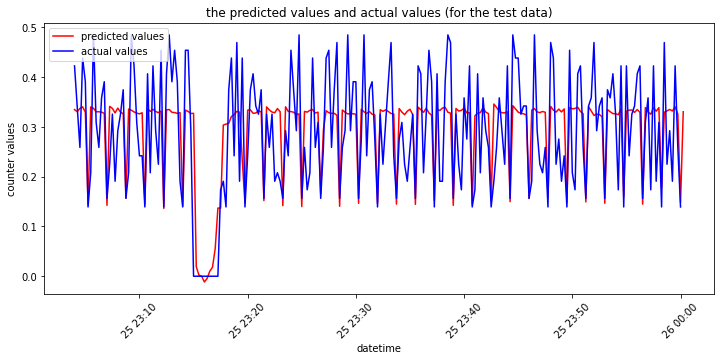

In [16]:
plot_result(test_df, pred_df, past_seq_len=ts_pipeline.internal.config['past_seq_len'])

In [17]:
mse, smape = ts_pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 0.007989756101803754
Evaluate: the smape value is 15.618997421556962


In [ ]:
from zoo.automl.config.recipe import MTNetGridRandomRecipe
ts_pipeline2 = trainer.fit(train_df, val_df, 
                          recipe=MTNetGridRandomRecipe(
                              num_rand_samples=5,
                              time_step=[10, 12, 14, 16],
                              long_num=[4, 5, 6, 7, 8],
                              ar_size=[10],
                              cnn_height=[3, 4, 5, 6, 8],
                              cnn_hid_size=[32, 64],
                              training_iteration=1,
                              epochs=10,
                              batch_size=[64]))

Trial name,status,loc,ar_size,batch_size,cnn_dropout,cnn_height,cnn_hid_size,long_num,lr,past_seq_len,rnn_dropout,selected_features,time_step,iter,total time (s)
train_func_00000,TERMINATED,,10,64,0.33601,8,64,5,0.00644027,60,0.436281,"[""IS_AWAKE(datetime)"", ""WEEKOFYEAR(datetime)"", ""DAYOFYEAR(datetime)"", ""WEEKDAY(datetime)"", ""DAY(datetime)"", ""HOUR(datetime)""]",10,1,785.929
train_func_00001,TERMINATED,,10,64,0.373845,5,32,7,0.00269399,96,0.2854,"[""WEEKOFYEAR(datetime)"", ""DAY(datetime)"", ""HOUR(datetime)""]",12,1,600.337
train_func_00002,TERMINATED,,10,64,0.230979,3,32,4,0.00947302,60,0.482335,"[""DAY(datetime)"", ""IS_AWAKE(datetime)"", ""MONTH(datetime)""]",12,1,365.153
train_func_00003,TERMINATED,,10,64,0.395742,3,32,4,0.00405656,70,0.370489,"[""DAY(datetime)"", ""HOUR(datetime)"", ""IS_AWAKE(datetime)"", ""DAYOFYEAR(datetime)""]",14,1,367.632
train_func_00004,RUNNING,,10,64,0.343446,3,64,6,0.00584638,98,0.374401,"[""WEEKOFYEAR(datetime)"", ""IS_WEEKEND(datetime)"", ""IS_AWAKE(datetime)"", ""WEEKDAY(datetime)"", ""DAY(datetime)"", ""DAYOFYEAR(datetime)"", ""IS_BUSY_HOURS(datetime)"", ""HOUR(datetime)"", ""MINUTE(datetime)""]",14,,


In [19]:
pred_df2 = ts_pipeline2.predict(test_df)

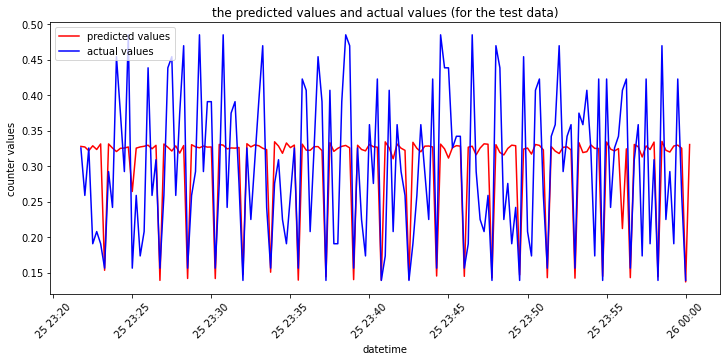

In [20]:
plot_result(test_df, pred_df2, past_seq_len=ts_pipeline2.internal.config['past_seq_len'])

In [21]:
mse2, smape2 = ts_pipeline2.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse2)
print("Evaluate: the smape value is", smape2)

Evaluate: the mean square error is 0.0077861733281103795
Evaluate: the smape value is 11.74788758030903


In [22]:
ts_pipeline2.internal.config['past_seq_len']

80